In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from colorline import colorline

%load_ext autoreload
%autoreload 2

# Replicator equation
We are interested here in the dynamics of a population of agents who play randomly against one another (the interaction graph is the complete graph).
The replicator equation models the dynamics of the fraction of player playing each strategies. Ie, it is an equation on a strategy vector $x \in \Delta_n$ where $\Delta_n$ is the n-simplex: $\sum_{i=1}^n x_i = 1$. $x_i$ is interpreted as the fraction of players playing strategy $i$.
We assume players are indistinguishable. In particular, they all share the same payoff matrix, $A$, defined as follows: $A_{i,j}$ is the payoff obtained by the focus player, when the focus player plays $i$ and their opponent plays $j$.

In the replicator model, the rate of change $\dot x_i/x_i$ of the fraction of players playing the $i^\text{th}$ strategy is equal to the difference between the expected payoff an individual would obtain by playing purely this strategy against the current population, $(A x)_i$, and the expected payoff they would obtain by following the current strategy: $x \cdot A x$:
$$
    \frac{\dot x_i}{x_i} = (Ax)_i - x \cdot A x
$$

# Simple Rock-Paper-Scissors game
This is the standard game, with payoff matrix:
$$
A = \begin{bmatrix} 
0 & -1 & 1 \\
1 & 0 & -1 \\
-1 & 1 & 0
\end{bmatrix}
$$
The strategy space is $\Delta_3$, which is conveniently 2-dimensional.

The expected value is always 0, so
$$
    \frac{\dot x_i}{x_i} = (Ax)_i
$$

The central point $(1/3, 1/3, 1/3)$ is the unique NE of the one-shot game. Let us define
$a_i = x_i - 1/3$.
Then,
$$
    \dot a = -(a + \frac{1}{3})(a + 2b) \\
    \dot b = (b + \frac{1}{3})(2a + b) \\
    c = -a -b
$$

In [5]:
# payoff matrix
A = np.array([[0,-1,1],[1,0,-1],[-1,1,0]], dtype=float)

In [188]:
t1 = 1/3
def func(t, y):
    """
    Act with the replicator operator on y = (a, b)
    
    Rk: does not explicitly depend on time t, but needed by solver
    """
    a, b = y
    
    y0p = -(a + t1)*(a + 2.*b)
    y1p = (b + t1)*(2.*a + b)
    return [y0p, y1p]

## Geometry
For visializations, we project strategy vectors $x \in R^3$ onto the image of the replicator operator, the simplex $\Delta_3$, which is the triangle of vertices $(0,0,1)$ and permutations thereof.

In [137]:
n = np.sqrt(2/3)
P = np.array([[-1/np.sqrt(2), 1/np.sqrt(2), 0], [-0.5*n, -0.5*n, n]])

def to_simplex(a, b):
    """
    Map v = (a - 1/3, b - 1/3, -a-b - 1/3) in R3
    to r = (x, y) in Delta_3, where Delta_3 is the 2-simplex
    """
    c = -a-b
    r = np.array([a, b, c]) + 1./3
    return P @ r

def init(E, x):
    """
    Return (a, b) associated with (E, x)
    Where E = x*y*z (invariant of motion of the simple RPS game)
    """
    assert x*(1-x)**2. >= 4.*E, "invalid (E, x) couple"
    y, _ = np.roots([x, x**2. - x, E])
    y = y.real
    return np.array([x - 1./3., y - 1./3.])

## Solving
Let $x = (x_1, x_2, x_3) \in R^3$ be a strategy vector.
Then, $E = x_1 \times x_2 \times x_3$ is a constant of motion of the replicator. The dynamics is effectively 1D, which we see in the simulations below.
$E$ is a monotonous function, with a minimum $E=0$ at the boundary of $\Delta_3$, and a maximum at the center.
When the value of $E$ is close 0, points accumulate close to the vertices of $\Delta_3$, ie, for long periods of time most individuals play a common strategy $i$. At some point, the system brutally crosses over to a phase where most individuals play the strategy $j$ that dominates $i$, and so on.

In [186]:
t_span = [0, 25]
E_list = np.array([0.6, 0.01])/3.**3
x = 0.3
y0s = [init(E, x) for E in E_list]
sols = [solve_ivp(func, t_span, y0, rtol=1e-8) for y0 in y0s]

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.


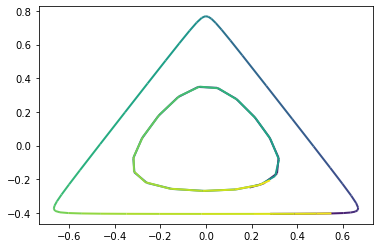

In [187]:
fig, ax = plt.subplots()
for sol in sols:
    print(sol.message)
    x, y = to_simplex(sol.y[0], sol.y[1])
    z = np.linspace(0, 1, len(x))
    colorline(ax, x, y, z, cmap=plt.get_cmap('viridis'), linewidth=2)

plt.show()

# Generalized RPS game
Let us generalized the payoff matrix:
$$
A = \begin{bmatrix} 
0 & -c & 1 \\
1 & 0 & -c \\
-c & 1 & 0
\end{bmatrix}
$$
to situations where $c \neq 1$.

Equations of motion:
$$
    \frac{\dot x}{x} = -cy + z - (1-c)(xy + yz + zx)\\
    \frac{\dot y}{y} = x -cz - (1-c)(xy + yz + zx)\\
    z = 1 - x - y
$$
## Results
* When $c>1$, the average gain is negative, and zero at the boundary: the population converges to the boundary
* When $c<1$, the average gain is positive, and maximal at the center: the population converges to the center

In [189]:
A = lambda c: np.array([[0,-c,1],[1,0,-c],[-c,1,0]], dtype=float)

In [48]:
def func(t, yvec, c):
    """
    Act with the replicator operator on yvec = (x, y)
    
    Rk: does not explicitly depend on time t, but needed by solver
    """
    x, y = yvec
    z = 1 - x - y
    
    mv = (1-c)*(x*y + y*z + z*x)
    
    y0p = x*(-c*y + z - mv)
    y1p = y*(x - c*z - mv)
    return [y0p, y1p]

n = np.sqrt(2/3)
P = np.array([[-1/np.sqrt(2), 1/np.sqrt(2), 0], [-0.5*n, -0.5*n, n]])

def to_simplex(x, y):
    """
    Map v = (x, y, z) in R3
    to r in Delta_3, where Delta_3 is the 2-simplex
    """
    z = 1-x-y
    return P @ np.array([x, y, z])

def init(E, x):
    """
    Return (x, y) associated with (E, x)
    Where E = x*y*z (invariant of motion of the simple RPS game)
    """
    assert x*(1-x)**2. >= 4.*E, "invalid (E, x) couple"
    y, _ = np.roots([x, x**2. - x, E])
    y = y.real
    return np.array([x, y])

In [71]:
c = 1.1
t_span = [0, 200]
E_list = np.array([0.6])/3.**3
x = 0.3
y0s = [init(E, x) for E in E_list]
sols = [solve_ivp(func, t_span, y0, rtol=1e-10, args=(c,)) for y0 in y0s]

The solver successfully reached the end of the integration interval.


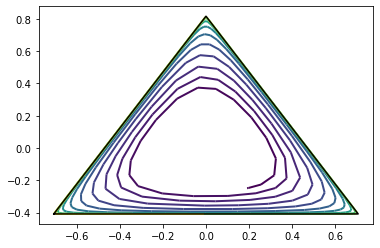

In [72]:
fig, ax = plt.subplots()
for sol in sols:
    print(sol.message)
    x, y = to_simplex(sol.y[0], sol.y[1])
    z = np.linspace(0, 1, len(x))
    colorline(ax, x, y, z, cmap=plt.get_cmap('viridis'), linewidth=2)

xb, yb = np.array([to_simplex(1, 0), to_simplex(0, 1), to_simplex(0, 0), to_simplex(1,0)]).T
ax.plot(xb, yb, 'k-')
    
plt.show()